ir Static Structure Factor

The `freud.diffraction` module provides two methods for calculating a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) $S(k)$ which can be used to characterise structure of crystals, liquids or amorphous phases.

The `freud.diffraction.StaticStructureFactorDirect` class implements a "direct" $S(k)$ method, which operates on a k-space grid:

$$S(k) = {\frac{1}{N}}\sum_{i=1}^{N}\sum_{j=1}^{N}\mathrm{e}^{-i\mathbf{k}\cdot(\mathbf{r}_{i} - \mathbf{r}_{j})}$$

For an excellent introduction to the theory of scattering and $S(k)$, please refer to the documentation of the [dynasor package](https://dynasor.materialsmodeling.org/), which performs a number of calculations related to scattering. We have re-implemented the core method of static structure factor calculation from dynasor in **freud** with some additional performance optimizations in parallelized C++ code, as well as an interface to compute $S(k)$ that aligns with the APIs and conventions of the **freud** analysis library.

The `freud.diffraction.StaticStructureFactorDebye` class computes static structure factor based on the Debye scattering equation:

$$ S(k) = {\frac{1}{N}} \sum_{i=1}^{N}\sum_{j=1}^{N}{\frac{\sin(kr_{ij})}{kr_{ij}}} $$

which is obtained by integrating out the angular dependence from the original formula. This implementation provides a much faster algorithm, but gives worse results than the "direct" method at low-k values.

Note that freud employs the usual physics convention, as opposed to the crystallographic convetion, with following expression linking the two: $k = 2\pi q$. Static structure factor is related to the radial distribution function, $g(r)$, by a Fourier Transform, i.e.

$$ S(k) = 1 + \rho \int_{V}\mathrm{d}\mathbf{r}e^{-i\mathbf{k}\cdot\mathbf{r}}g(r). $$

## Lennard-Jones liquid example

One of the use cases for $S(k)$ is to characterize structure of liquids. The example shown here uses points that were generated from a HOOMD-blue simulation of a 1000-particle system subject to the Lennard-Jones potential, see HOOMD-blue [documentation](https://hoomd-blue.readthedocs.io/en/latest/) and [examples](https://github.com/glotzerlab/hoomd-examples).

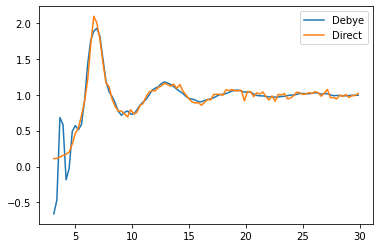

In [1]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np

bins = 100
k_max = 30
k_min = 3
sfDirect = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min
)
sfDebye = freud.diffraction.StaticStructureFactorDebye(
    bins=bins, k_max=k_max, k_min=k_min
)

with gsd.hoomd.open("data/LJsampletraj.gsd", "rb") as traj:
    for frame in traj:
        sfDebye.compute(frame, reset=False)
        sfDirect.compute(frame, reset=False)

plt.plot(sfDebye.bin_centers, sfDebye.S_k, label="Debye")
plt.plot(sfDirect.bin_centers, sfDirect.S_k, label="Direct")
plt.legend()
plt.show()

## Crystal comparsion example
Static structure factor $S(k)$ can also be used to characterize and compare crystal structures. In the below example we compare the computed static structure factors $S(k)$ of a face-centered cubic (fcc) crystal and simple cubic (sc) crystal.

<class 'numpy.ndarray'> [[ 7.8556538e-02  1.3181448e-01 -8.2010269e-02]
 [ 4.5295715e-02  7.6341629e-03  1.0692024e+00]
 [ 2.2850037e-03 -7.7362061e-02  1.8331623e+00]
 ...
 [-1.1639130e+00 -1.0460019e+00 -2.8816521e+00]
 [-7.7807188e-01 -1.0529876e+00 -2.2228265e+00]
 [-9.6693754e-01 -8.7425947e-01 -1.0415196e+00]]


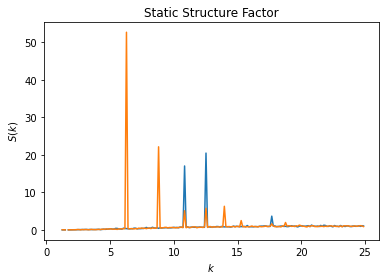

In [2]:
import freud
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sf = freud.diffraction.StaticStructureFactorDirect(bins=200, k_max=25, k_min=1)
fccsystem = freud.data.UnitCell.fcc().generate_system(10, sigma_noise=0.10)
sf.compute(fccsystem)
sf.plot(ax=ax)

scsystem = freud.data.UnitCell.sc().generate_system(10, sigma_noise=0.10)
box, points = scsystem
print(type(points), points)
sf.compute(scsystem)
sf.plot(ax=ax)

plt.show()

## Calculation of partial structure factors

Both methods support calculation of partial structure factors according to [Faber-Ziman decomposition](https://freud--821.org.readthedocs.build/en/820/modules/diffraction.html#freud.diffraction.StaticStructureFactorDirect) {***UPDATE LINK AFTER CLOSING PR***}{should we incluede the formula for decomposition here?}. In our implementation summation of partials reproduces the total scattering. In this example we load GeS$_2$ trajectory and calculate the Ge-Ge partial, the S-S partial and the mixed Ge-S partial (which is the same as S-Ge partial). The calculation of the partials requires the usage of `query_points` and `N_total` parameters for the compute method.

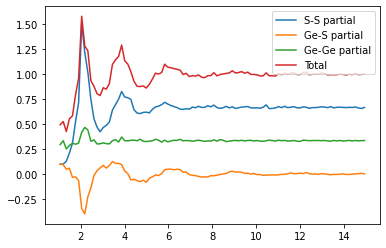

In [10]:
import freud
import matplotlib.pyplot as plt
import numpy as np

# read in xyz file
# read number of particles
N_particles = int(np.genfromtxt("data/ges2.xyz", max_rows=1, dtype=int))
cleaned_data = []
# remove lines that don't contain particle data
with open("data/ges2.xyz") as f:
    for line in f:
        if line[0] != "\n" and line[0] != " ":
            cleaned_data.append(line)

positions = np.genfromtxt(cleaned_data)[:, 1:4].reshape(-1, N_particles, 3)
particle_types = np.genfromtxt(cleaned_data, dtype=str)[:, 0].reshape(-1, N_particles)

box = freud.Box.cube(19.21)

# max_k_points is the number of k-points used in the calculation,
# higher values give better S(k) but takes longer
max_k_points = 200000
k_max = 15
k_min = 1
bins = 100
sfGe_Ge = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min, max_k_points=max_k_points
)
sfGe_S = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min, max_k_points=max_k_points
)
sfS_S = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min, max_k_points=max_k_points
)

for frame, ptypes in zip(positions, particle_types):
    Ge_positions = frame[ptypes == "Ge"]
    S_positions = frame[ptypes == "S"]
    sfGe_Ge.compute(
        (box, Ge_positions), query_points=Ge_positions, N_total=N_particles, reset=False
    )
    sfGe_S.compute(
        (box, S_positions), query_points=Ge_positions, N_total=N_particles, reset=False
    )
    sfS_S.compute(
        (box, S_positions), query_points=S_positions, N_total=N_particles, reset=False
    )

plt.plot(sfS_S.bin_centers, sfS_S.S_k, label="S-S partial")
plt.plot(sfGe_S.bin_centers, sfGe_S.S_k, label="Ge-S partial")
plt.plot(sfGe_Ge.bin_centers, sfGe_Ge.S_k, label="Ge-Ge partial")

S_tot = sfGe_S.S_k + sfS_S.S_k + sfGe_Ge.S_k
plt.plot(sfGe_Ge.bin_centers, S_tot, label="Total")
plt.legend(loc="upper right")
plt.show()